# Generate a stone like geometry

Idea here is to generate a set of random points, pick some in the middle that are inside an ellipsoid and compute the surface of the Voronoi tesselation of the points inside with the points outside.

In [180]:
import numpy as np
import matplotlib.pyplot as plt

In [181]:
param = {
    'dims': (128, 128, 50),
    'numCells': 600,
}
fudge = 0.1
po = []
for i in range(param['numCells']):
    x = fudge + (np.random.rand(1)-.5) * (param['dims'][0]-1-fudge)
    y = fudge + (np.random.rand(1)-.5) * (param['dims'][1]-1.-fudge)
    z = fudge + (np.random.rand(1)-.5) * (param['dims'][2]-1.-fudge)
    po.append([x.item(),y.item(),z.item()])

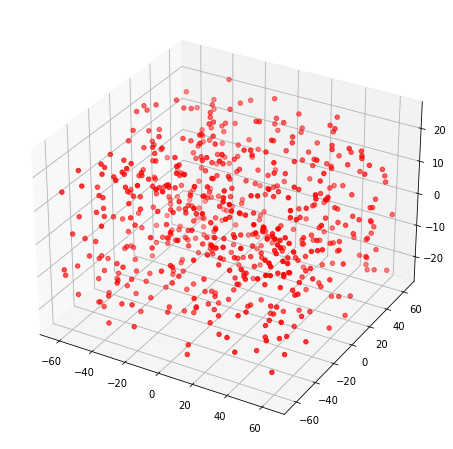

In [182]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([item[0] for item in po],[item[1] for item in po],[item[2] for item in po],c='r',marker='o')

Just use the square of a random 3x3 matrix and scale it appropriately. From there we can use a quadratic form to test if a point is inside or outside.

In [183]:
tbt = (np.random.rand(9)-.5).reshape((3,3))
# squaring a random matrix gives us a positive definite matrix
#tbt = np.square(tbt)
#[evals, evects] = np.linalg.eig(tbt)
# using svd we expect the eigenvalues to be positive
u, D, uh = np.linalg.svd(tbt, full_matrices=True, hermitian=True)
# substituting our own eigenvalues back in
D = np.diag((1/40,1/20,1/10))

# This would be our new (positive definite) matrix with random rotation, ready for our quadratic form
A = (u @ D) @ uh
print(np.linalg.eig(A))

(array([-0.025,  0.1  ,  0.05 ]), array([[-0.71609357,  0.6890365 , -0.11152893],
       [ 0.2641137 ,  0.11957465, -0.9570506 ],
       [ 0.64610677,  0.7147941 ,  0.26761061]]))


In [184]:
def distance(v, A):
    v = v.reshape((3,1))
    #print(np.transpose(v) @ A @ v, v)
    b = (np.transpose(v) @ A) @ v
    if (b < 0):
        print("negative", b)
        b = abs(b)
    return np.sqrt(b)

# return 1 or zero if the point is inside the ellipsoid
def classify(po, A):
    classes = []
    for i in range(len(po)):
        if distance(np.asarray(po[i]),A) < 1:
            classes.append(1)
        else:
            classes.append(0)
    return classes
cls = classify(po, A)
#cls

negative [[-5.27697925]]
negative [[-29.16281516]]
negative [[-11.45304285]]
negative [[-36.00280194]]
negative [[-24.21402773]]
negative [[-27.04846027]]
negative [[-1.42049314]]
negative [[-9.8883627]]
negative [[-0.46016974]]
negative [[-49.58368231]]
negative [[-16.27906292]]
negative [[-21.07832138]]
negative [[-11.7710903]]
negative [[-55.25688928]]
negative [[-24.69458826]]
negative [[-6.14850201]]
negative [[-8.57196502]]
negative [[-26.31473755]]
negative [[-30.8866627]]
negative [[-5.17479897]]
negative [[-3.98071254]]
negative [[-7.78302668]]
negative [[-19.30884282]]
negative [[-35.00044224]]
negative [[-3.83715]]
negative [[-20.63538298]]
negative [[-28.0094107]]
negative [[-3.19604631]]
negative [[-18.98428666]]
negative [[-5.48139944]]
negative [[-8.7388179]]
negative [[-22.33058835]]
negative [[-35.8539785]]
negative [[-3.59659893]]
negative [[-11.73973647]]
negative [[-5.14318887]]
negative [[-33.23588362]]
negative [[-5.45097276]]
negative [[-22.12210453]]
negative [[

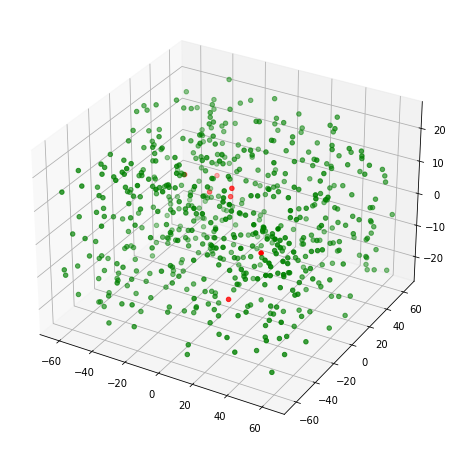

In [185]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
poIn = [po[i] for i in range(len(po)) if cls[i] == 1]
poOut = [po[i] for i in range(len(po)) if cls[i] == 0]
ax.scatter([item[0] for item in poIn],[item[1] for item in poIn],[item[2] for item in poIn],c='r',marker='o')
ax.scatter([item[0] for item in poOut],[item[1] for item in poOut],[item[2] for item in poOut],c='g',marker='o')

In [186]:
len(poIn), len(poOut)

(7, 593)

In [187]:
u, D, uh = np.linalg.svd(A)

In [188]:
u, D, uh

(array([[-0.6890365 ,  0.11152893,  0.71609357],
        [-0.11957465,  0.9570506 , -0.2641137 ],
        [-0.7147941 , -0.26761061, -0.64610677]]),
 array([0.1  , 0.05 , 0.025]),
 array([[-0.6890365 , -0.11957465, -0.7147941 ],
        [ 0.11152893,  0.9570506 , -0.26761061],
        [-0.71609357,  0.2641137 ,  0.64610677]]))

In [189]:
np.linalg.eig(A)

(array([-0.025,  0.1  ,  0.05 ]),
 array([[-0.71609357,  0.6890365 , -0.11152893],
        [ 0.2641137 ,  0.11957465, -0.9570506 ],
        [ 0.64610677,  0.7147941 ,  0.26761061]]))

In [190]:
po


[[22.735832700002046, 24.682183347787525, 20.21426193383752],
 [58.89689470659967, 46.82229106396937, 0.20879112443990064],
 [53.482270954033964, 28.51823639119241, 21.846244815433213],
 [-3.8524526485762127, 54.470932772058106, 15.287390233469276],
 [-30.582270151605357, 24.259064304753775, -10.535490844814431],
 [-20.73976548728767, 45.03424519873129, 8.680698937482301],
 [-49.163877970852816, -45.79368769597728, -22.77561413878161],
 [39.68319204800497, 36.31820348089006, 18.991234531301515],
 [36.58465221944449, 12.67437231273824, -5.571229885258106],
 [-62.16428998865344, -28.856280836584894, 7.864696086247294],
 [-31.602066148194847, 46.539055009652195, 12.725803399600524],
 [46.385484567862214, -57.368126517419824, 19.95538101759519],
 [-7.324856792703025, 49.77222583248342, -11.659656971718604],
 [-54.78022621438523, 3.8884831890763962, 6.1715797603075515],
 [56.21767769030542, -25.010351533286425, -14.525774581605901],
 [-32.25538612179777, -44.95507433125146, -11.739226534562